In [1]:
import pandas as pd
import yaml
import pickle
import os
import logging
import warnings
from utilities.utilities import *
from utilities.plotting import plot_exposure_contour, plot_gdp_increase_scatter
from utilities.plotting import plot_variable_map, plot_cdd_scatter, plot_income_groups
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr

In [2]:
# Load configuration from config.yaml
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)
logging.basicConfig(level=config['logging_level'])
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read in often used values from config
with open('data/exposure_function_params.pkl', 'rb') as f:
    params = pickle.load(f)


ref_year = config['analysis_years']['ref_year']
past_year = config['analysis_years']['past_year']
future_year = config['analysis_years']['future_year']

outfile_path = config['output_path']

# Read in income groups from World Bank data
income_groups = read_income_classification(config['world_bank_income_groups_file'], ref_year)

In [3]:
def exposure_new(cdd, gdp):
    """
    Return exposure (= 1 - AC adoption) with parameter values
    """
    return exposure_combined_exponential((cdd, gdp), params['alpha'], params['beta'], params['gamma'])

In [4]:
# Collect country-level data, only recalculate if the file does not exist

if os.path.exists(outfile_path):
    logging.info('Reading in experienced temperature data from file {}'.format(outfile_path))
    # Read in the data
    ac_data = pd.read_csv(outfile_path)

else:
    logging.info('Cooling deficit Index analysis results not found, recalculating')

    # Read the historical cooling degree days data
    cdd_data = read_cdd_data(config['cdd_historical_file'])
    

    # Read the historical GDP data
    gdp_data = read_gdp_data(config['gdp_historical_file'])
    gdp_data_years = []
    for year in [past_year, ref_year]:
        gdp_data_year = gdp_data[gdp_data['Year'] == year]
        fill_missing_country_gdp_data(year, gdp_data_year, config)
        if year == past_year:
            gdp_data_year = gdp_data_year.rename(columns={'GDP': 'GDP_past'})
            gdp_data_year = gdp_data_year.rename(columns={'Year': 'Year_past'})
        gdp_data_years.append(gdp_data_year)
    gdp_data = pd.merge(gdp_data_years[0], gdp_data_years[1], on='ISO3')

    ac_data_historical = pd.merge(cdd_data, gdp_data, on=['ISO3', 'Year'], how='left')
    ac_data_historical = ac_data_historical.rename(columns={'Year': 'Year_ref'})
        
    # Add historical annual GDP growth
    ac_data_historical['gdp_historical_growth'] = calculate_average_gdp_growth(ac_data_historical['GDP'], 
            ac_data_historical['GDP_past'], ac_data_historical['Year_ref'] - ac_data_historical['Year_past'])

    # Add predictions for CDD in 2100 in different scenarios
    cdd_projections = read_projections(config, 'cdd', ac_data_historical, year=config['analysis_years']['future_year'])
    
    # Combine historical and projections into one dataframe
    ac_data = pd.merge(ac_data_historical, cdd_projections, on='ISO3', how='outer')
    # Make sure all names are the same
    ac_data["Country"] = coco.convert(names=ac_data["ISO3"].tolist(), to='name_short')

    # Add income group
    ac_data = pd.merge(ac_data, income_groups, on='ISO3', how='left')

    # Formatting
    ac_data_all = ac_data.copy()
    # Drop rows where year past, CDD, GDP, or income group is NaN
    ac_data = ac_data.dropna(subset=['Year_past', 'CDD', 'GDP', 'income_group'])
    print("\n##################")
    # COuntries that are in ac_data_all but not in ac_data
    print("Countries dropped due to missing past year/GDP/CDD/income_group:\n", ac_data_all[~ac_data_all["Country"].isin(ac_data["Country"])]["Country"].unique())
    print("##################\n")
    ac_data.reset_index(drop=True, inplace=True)
    ac_data['Year_past'] = ac_data['Year_past'].astype(int)

    # Replace infinities with empty values
    ac_data = ac_data.replace(np.inf, np.nan)

    # Add column for historical heat exposure
    ac_data['exposure_times_cdd'] = exposure_new(ac_data['CDD'], ac_data['GDP'])*ac_data['CDD']
    ac_data['ac_adoption'] = 1. - exposure_new(ac_data['CDD'], ac_data['GDP'])
    
    # Calculate GDP needed to keep heat exposure constant
    ac_data_future = ac_data.dropna(subset=['CDD_ssp2_rcp45_{}'.format(config['analysis_years']['future_year'])])
    print("Countries dropped because no future CDD: {}".format(ac_data[~ac_data["Country"].isin(ac_data_future["Country"])]["Country"].unique()))
    ac_data_future.reset_index(drop=True, inplace=True)
    ac_data = calculate_gdp_const(ac_data_future, config, params)
    
print(ac_data)

INFO:root:Reading in experienced temperature data from file data/cooling_deficit_index_calculations.csv


     Unnamed: 0 ISO3         CDD  Year_ref  Year_past       GDP_past  \
0             0  AFG   876.75506      2019       2002    1280.463171   
1             1  AGO  2169.94281      2019       1990    5793.084512   
2             2  ALB   630.35247      2019       1990    4827.027705   
3             3  ARE  3865.06517      2019       1990  105893.626059   
4             4  ARG   850.95843      2019       1990   14136.525401   
..          ...  ...         ...       ...        ...            ...   
160         160  VUT  2693.38866      2019       1990    2774.138350   
161         161  WSM  3105.88948      2019       1990    3655.951872   
162         162  ZAF   824.97062      2019       1990   10391.964137   
163         163  ZMB  1596.08778      2019       1990    2290.039226   
164         164  ZWE  1442.73567      2019       1990    2704.757299   

              GDP  gdp_historical_growth  CDD_ssp1_rcp26_2100  \
0     2079.921861               0.028947               1078.0   
1    

In [5]:
# Get income group averages of CDD and GDP
ac_data_income_group = ac_data[['CDD', 'GDP', 'income_group']]
# Print number of countries in each income group
print("\n##################")
print("Number of countries in each income group: ")
print(ac_data_income_group['income_group'].value_counts())
print("##################\n")

ac_data_income_group = ac_data_income_group.groupby('income_group').median()

# Recalculate exposure times CDD for income groups
ac_data_income_group['exposure_times_cdd'] = exposure_new(ac_data_income_group['CDD'], ac_data_income_group['GDP'])*ac_data_income_group['CDD']

print("\n##################")
print("Income group median values: ")
print(ac_data_income_group)
print("##################\n")

# Add column to ac_data for GDP needed to get everyone to the exposure times cdd of the high income group
ac_data = calculate_gdp_const(ac_data, config, params, exp_cdd=ac_data_income_group.loc['high', 'exposure_times_cdd'])

# Write full dataframe to csv
if not os.path.exists(outfile_path):
    ac_data.to_csv(outfile_path)


##################
Number of countries in each income group: 
high            50
lower middle    46
upper middle    45
low             24
Name: income_group, dtype: int64
##################


##################
Income group median values: 
                      CDD           GDP  exposure_times_cdd
income_group                                               
high           407.180895  42748.820140          202.531097
low           2963.015960   1981.831442         2905.289605
lower middle  2506.558820   5372.018004         2332.195904
upper middle  1383.039630  14851.648588         1061.969451
##################



/Users/awongel/Projects/clab_experiencedT/utilities/utilities.py:213: RuntimeWarning: invalid value encountered in power
  return np.exp(-alpha * ((CDD / 1e3) ** (beta * GDP / 1e6) * (GDP / 1e6) ** gamma))*CDD - f
/Users/awongel/Projects/clab_experiencedT/utilities/utilities.py:225: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  GDP_solutions[i] = fsolve(equation, initial_guess, args=(exposure_cdd[i], cdd[i]))[0]


In [6]:
# Get the color on the GDP map for each income group in RGB
cmap = plt.cm.get_cmap(config['plotting']['gdp_cmap'])
norm = mcolors.LogNorm(vmin=config['plotting']['gdp_min'], vmax=config['plotting']['gdp_max'])
ac_data_income_group['gdp_color'] = ac_data_income_group['GDP'].apply(lambda x: mcolors.rgb2hex(cmap(norm(x))))
print("\n##################")
print("Colors for income groups used in plots:")
print(ac_data_income_group['gdp_color'])
print("##################\n")


##################
Colors for income groups used in plots:
income_group
high            #84d44b
low             #463480
lower middle    #2d708e
upper middle    #20a486
Name: gdp_color, dtype: object
##################



In [7]:
# Add CDD difference between 2100 and ref year
for scenario in config['future_scenarios']:
    ac_data['CDD_{0}_{1}_diff'.format(scenario, future_year)] = ac_data['CDD_{0}_{1}'.format(scenario, future_year)] - ac_data['CDD']

In [8]:
print("NUMERICAL VALUES QUOTED IN PUBLICATION:\n")

print("\n##################")
print("\nRelated to Fig.1")
ac_data_no_nans = ac_data.dropna(subset=['CDD', 'GDP'])
corr = pearsonr(ac_data_no_nans['CDD'], ac_data_no_nans['GDP'].apply(np.log))[0]
p_value = pearsonr(ac_data_no_nans['CDD'], ac_data_no_nans['GDP'].apply(np.log))[1]
# Print countries with CDD diff nan
ac_data_no_nans = ac_data_no_nans.dropna(subset=['CDD_ssp2_rcp45_2100_diff', 'GDP'])
corr_diff = pearsonr(ac_data_no_nans['CDD_ssp2_rcp45_2100_diff'], ac_data_no_nans['GDP'].apply(np.log))[0]
p_value_diff = pearsonr(ac_data_no_nans['CDD_ssp2_rcp45_2100_diff'], ac_data_no_nans['GDP'].apply(np.log))[1]
print("Correlation of CDD and log of GDP: {}, with p-value: {}".format(corr, p_value))
print("Correlation of CDD increase and GDP: {}, with p-value: {}".format(corr_diff, p_value_diff))

# Minimum and maximum CDD for low income group, round to integer
print("\n##################")
print("\nRelated to Fig.2")
print("Average CDD increase for all countries: {}".format(ac_data['CDD_ssp2_rcp45_2100_diff'].mean()))
print("Minimum CDD for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD'].min()))
print("Maximum CDD for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD'].max()))
print("Maximum CDD increase for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD_ssp2_rcp45_2100_diff'].max()))
# Countries of low income group with less than 500 CDD diff
print("Countries of low income group with less than 500 CDD increase: ", ac_data[(ac_data['income_group'] == 'low') & (ac_data['CDD_ssp2_rcp45_2100_diff'] < 500)]['Country'].values)
print("##################\n")

print("\n##################")
print("\nRelated to Fig.3")
# Print GDP increase for low income group to get to today's high income CDI
print("GDP factor for low income group to get to today's high income CDI: {}".format(gdp_from_cdd_exposure(ac_data_income_group.loc['high', 'exposure_times_cdd'], [ac_data_income_group.loc['low', 'CDD']], params)/ac_data_income_group.loc['low', 'GDP']))
print("##################\n")

print("\n##################")
print("\nRelated to Fig.4")
# Print GDP factor getting CDI to high income value over avoiding CDI increase
growth_ratio = ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45_custom_exp_cdd']/ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45']
print('GDP growth ratio of reaching high income CDI over avoiding increase in CDI for low income group: {}'.format(growth_ratio.mean()))
print('Low income group GDP growth rates: historical {}; to avoid increase in CDI {}; to reach high income CDI {}'
      .format(ac_data[ac_data['income_group'] == 'low']['gdp_historical_growth'].mean(), ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45'].mean(), 
              ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45_custom_exp_cdd'].mean()))
print("##################\n")

print("\n##################")
print("\nRelated to Methods")
# Countries with CDD smaller than the projection
print("Countries with CDD smaller than the projection in 2100 for SSP1 RCP 2.6:")
print(ac_data[ac_data['CDD_ssp1_rcp26_2100'] < ac_data['CDD']]['Country'].values)
print("Countries with CDD smaller than the projection in 2100 for SSP2 RCP 4.5:")
print(ac_data[ac_data['CDD_ssp2_rcp45_2100'] < ac_data['CDD']]['Country'].values)
print("Countries with CDD smaller than the projection in 2100 for SSP5 RCP 6.0:")
print(ac_data[ac_data['CDD_ssp5_rcp60_2100'] < ac_data['CDD']]['Country'].values)
print("##################\n")

NUMERICAL VALUES QUOTED IN PUBLICATION:


##################

Related to Fig.1
Correlation of CDD and log of GDP: -0.4599900783731685, with p-value: 5.109489175058067e-10
Correlation of CDD increase and GDP: -0.5265898412354599, with p-value: 3.7353534499691634e-13

##################

Related to Fig.2
Average CDD increase for all countries: 573.7074855151515
Minimum CDD for low income group: 725.05754
Maximum CDD for low income group: 3993.88824
Maximum CDD increase for low income group: 1134.99004
Countries of low income group with less than 500 CDD increase:  ['Afghanistan' 'Madagascar' 'Tajikistan']
##################


##################

Related to Fig.3
GDP factor for low income group to get to today's high income CDI: 0    30.354308
dtype: float64
##################


##################

Related to Fig.4
GDP growth ratio of reaching high income CDI over avoiding increase in CDI for low income group: 1.6726031177241258
Low income group GDP growth rates: historical 0.010827158191

/Users/awongel/Projects/clab_experiencedT/utilities/utilities.py:213: RuntimeWarning: invalid value encountered in power
  return np.exp(-alpha * ((CDD / 1e3) ** (beta * GDP / 1e6) * (GDP / 1e6) ** gamma))*CDD - f


<Figure size 640x480 with 0 Axes>

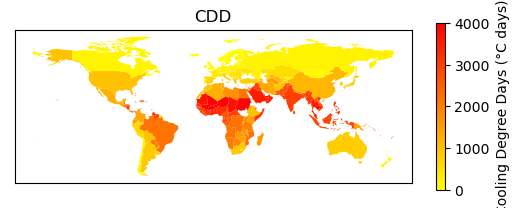

<Figure size 640x480 with 0 Axes>

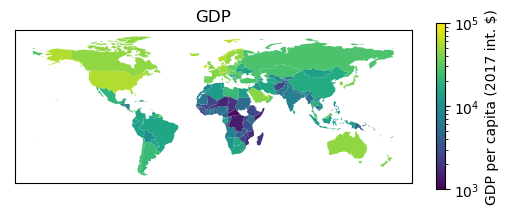

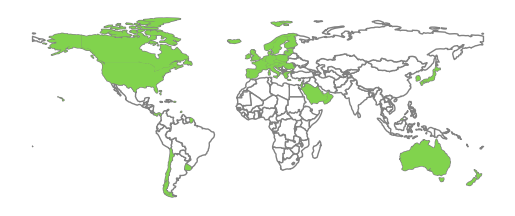

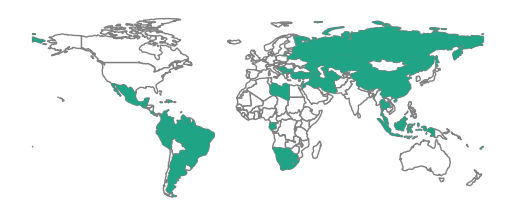

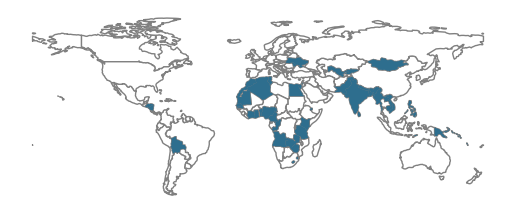

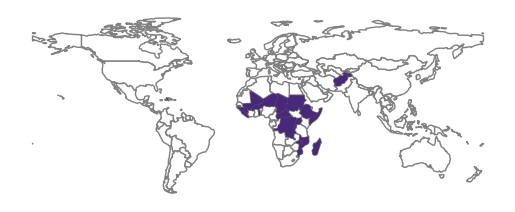

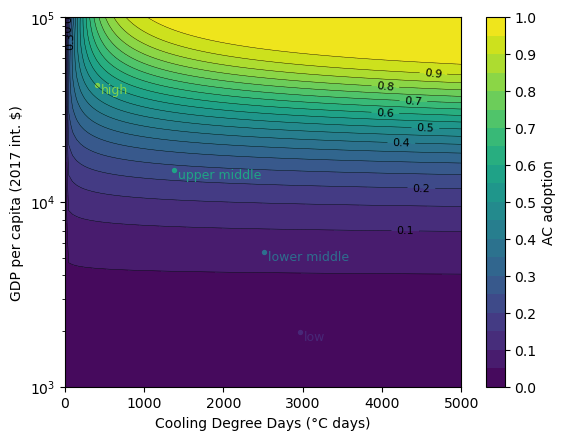

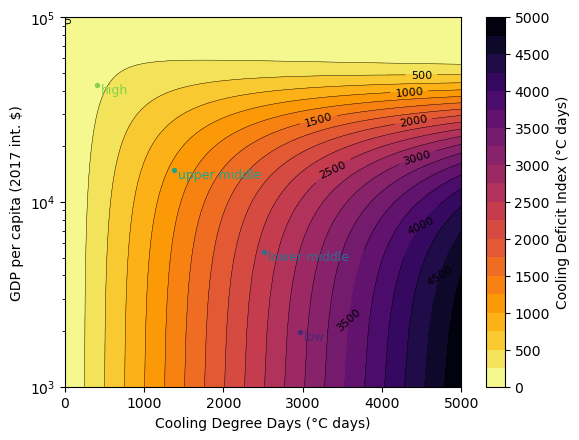

<Figure size 640x480 with 0 Axes>

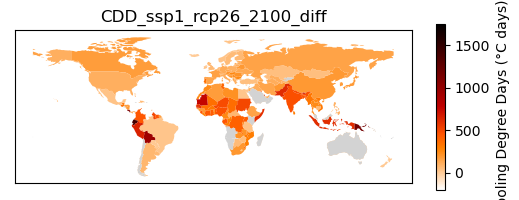

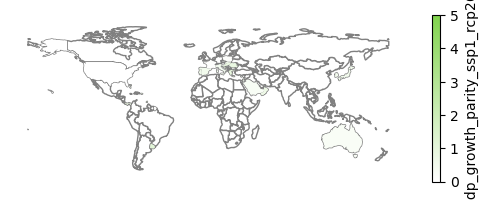

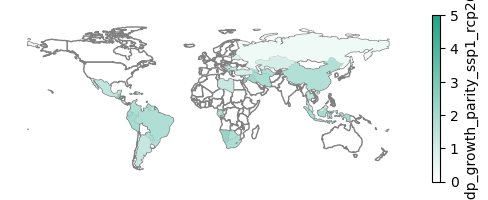

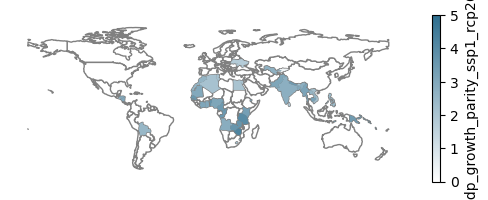

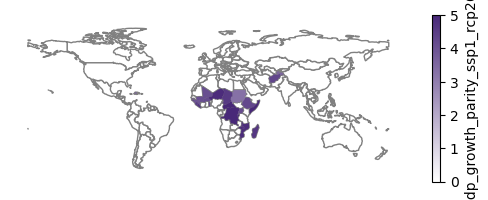

<Figure size 640x480 with 0 Axes>

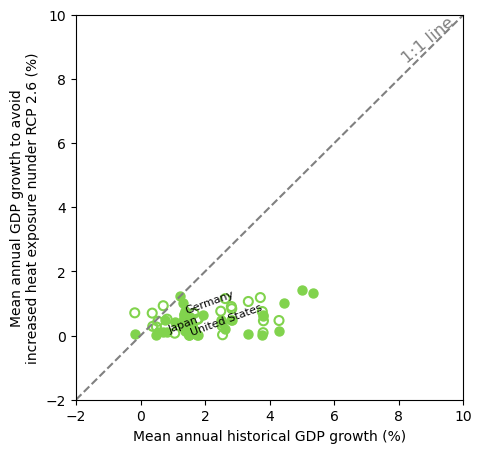

<Figure size 640x480 with 0 Axes>

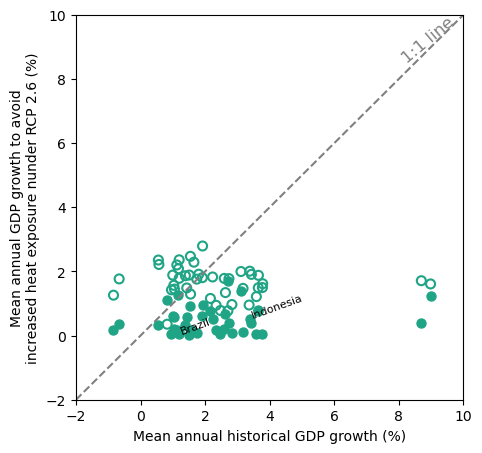

<Figure size 640x480 with 0 Axes>

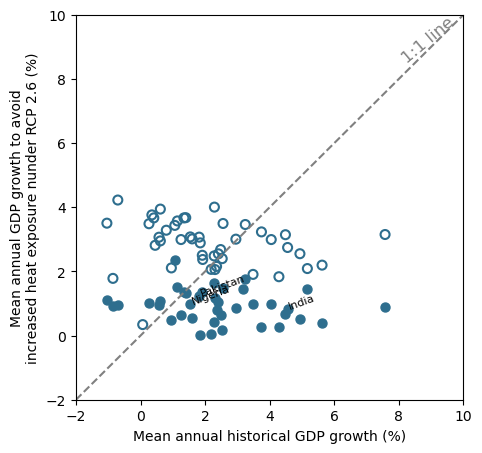

<Figure size 640x480 with 0 Axes>

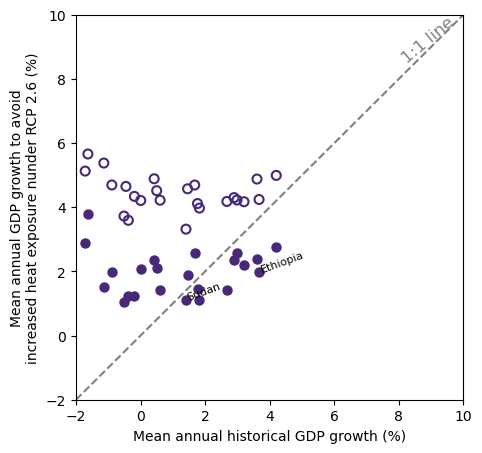

<Figure size 640x480 with 0 Axes>

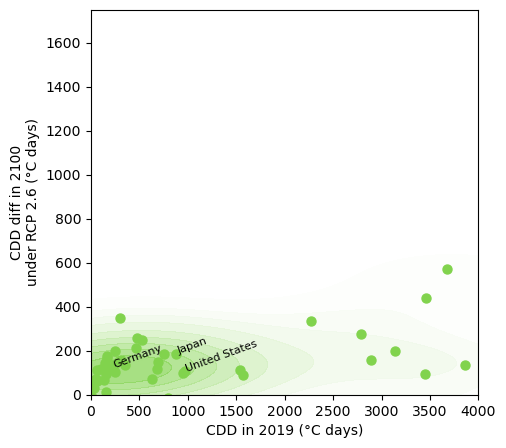

<Figure size 640x480 with 0 Axes>

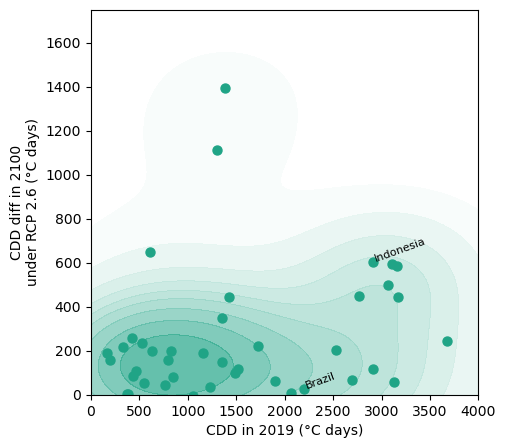

<Figure size 640x480 with 0 Axes>

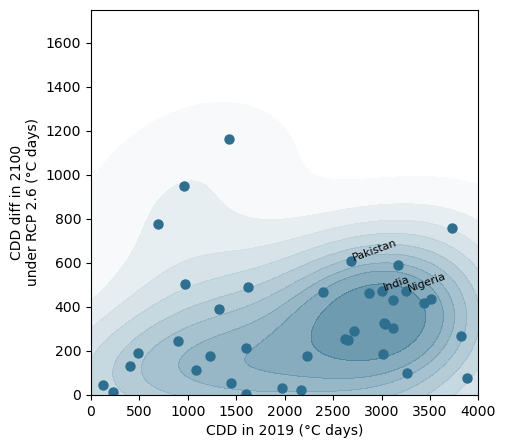

<Figure size 640x480 with 0 Axes>

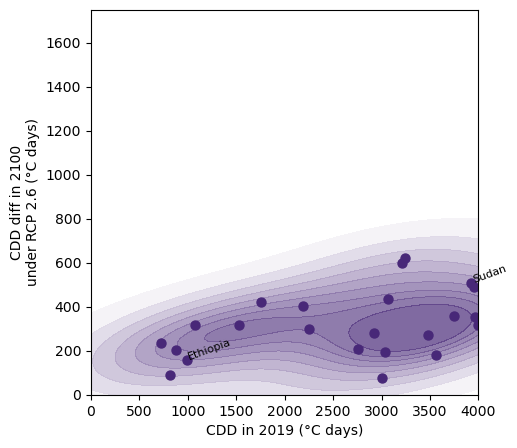

/Users/awongel/Projects/clab_experiencedT/utilities/plotting_classes.py:125: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  grey_countries.plot(ax=plt.gca(), color='lightgrey')


<Figure size 640x480 with 0 Axes>

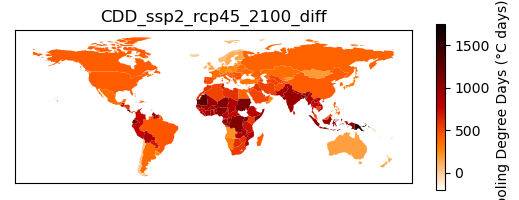

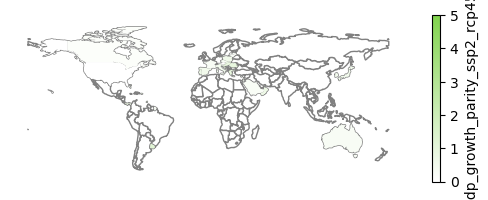

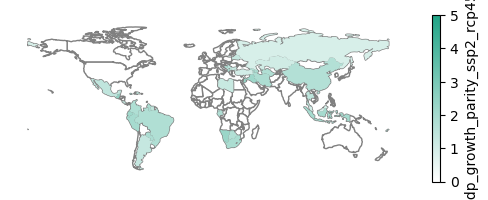

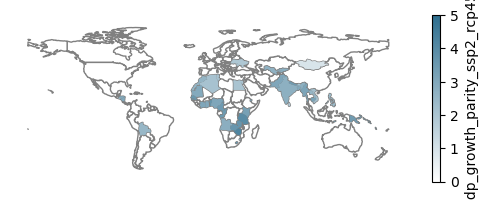

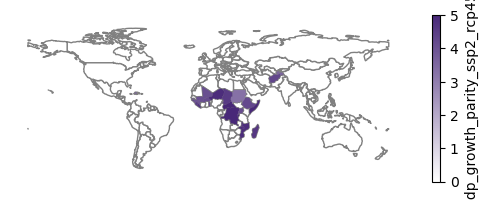

<Figure size 640x480 with 0 Axes>

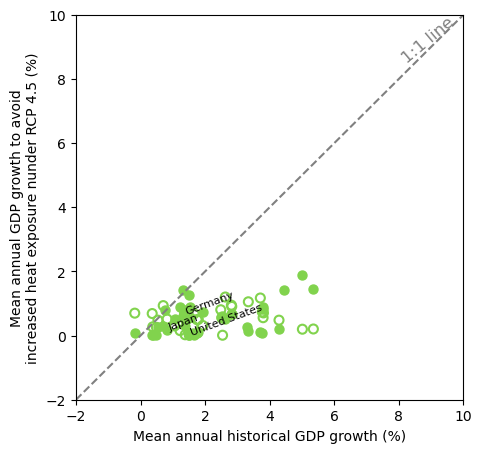

<Figure size 640x480 with 0 Axes>

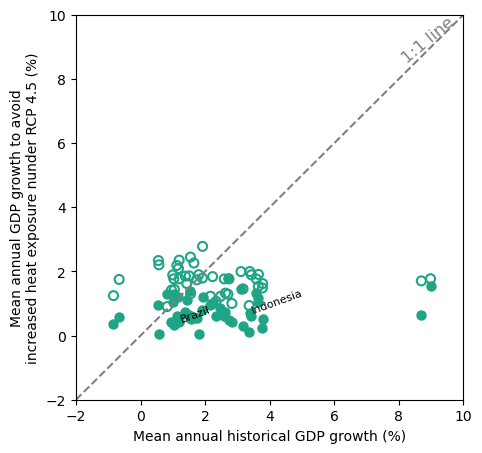

<Figure size 640x480 with 0 Axes>

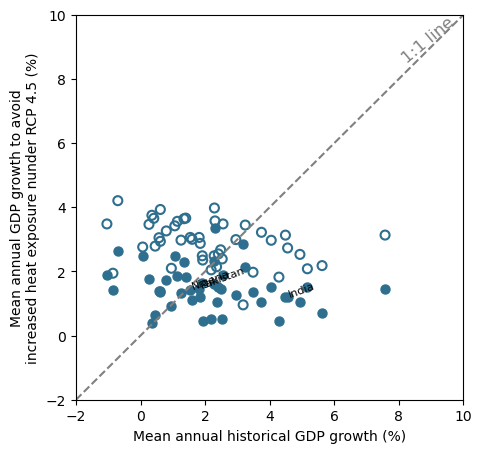

<Figure size 640x480 with 0 Axes>

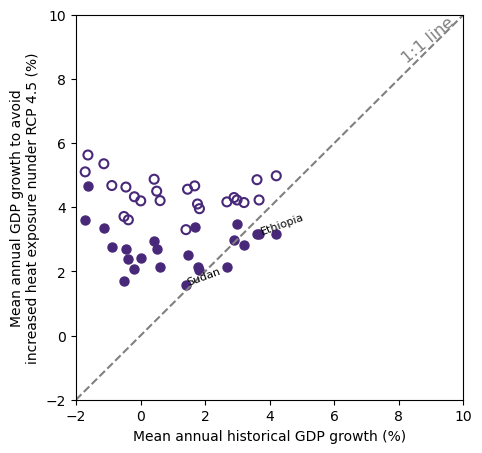

<Figure size 640x480 with 0 Axes>

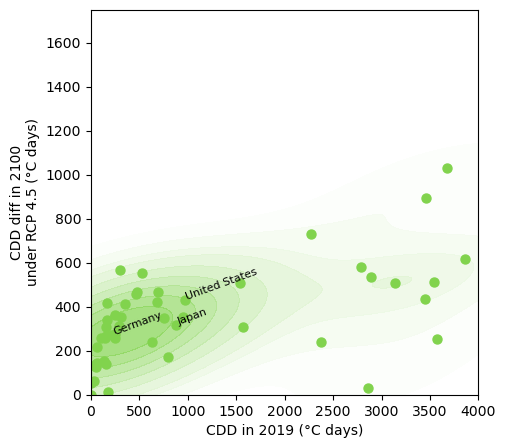

<Figure size 640x480 with 0 Axes>

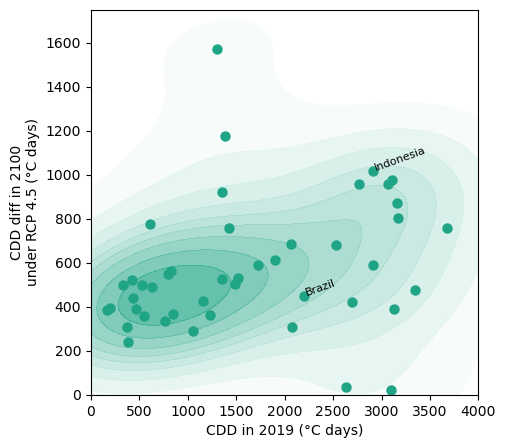

<Figure size 640x480 with 0 Axes>

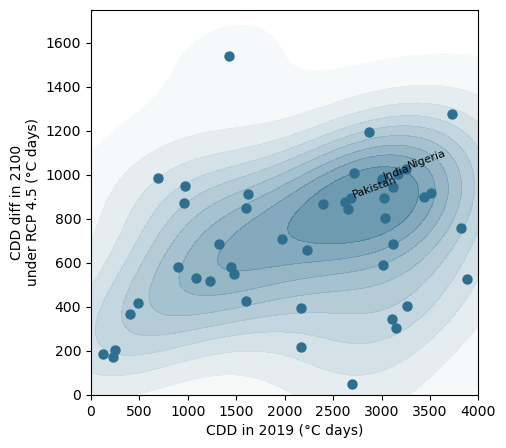

<Figure size 640x480 with 0 Axes>

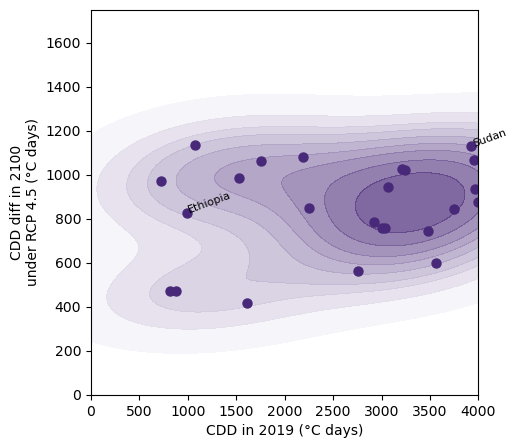

<Figure size 640x480 with 0 Axes>

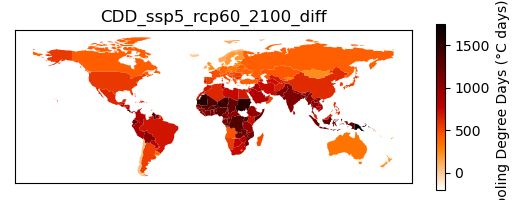

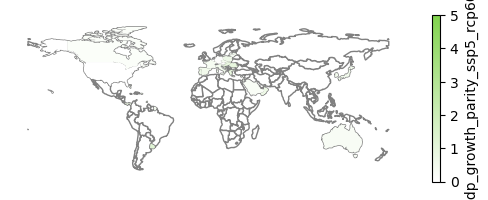

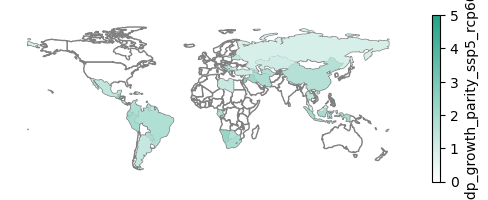

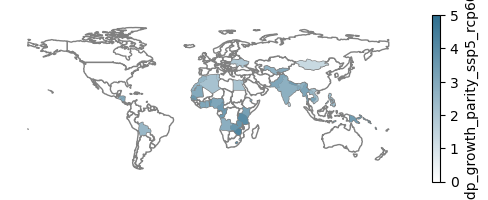

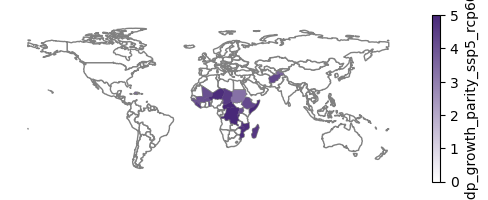

<Figure size 640x480 with 0 Axes>

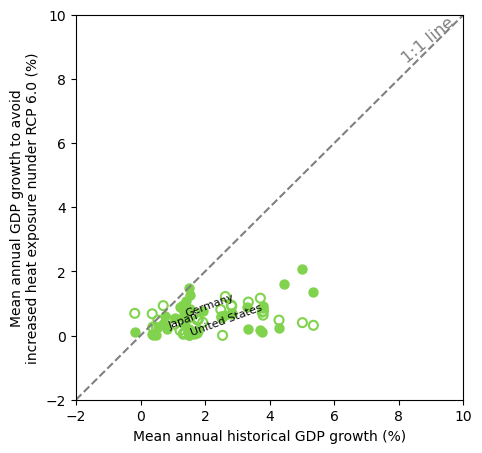

<Figure size 640x480 with 0 Axes>

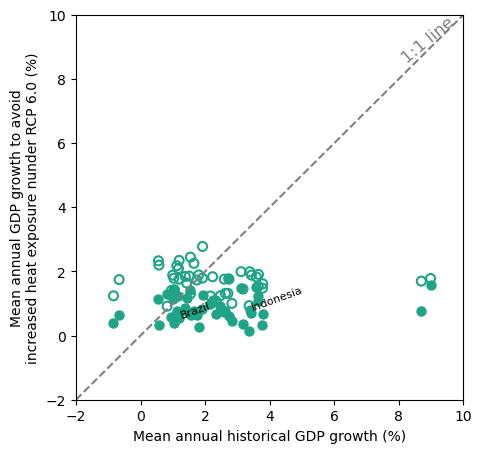

<Figure size 640x480 with 0 Axes>

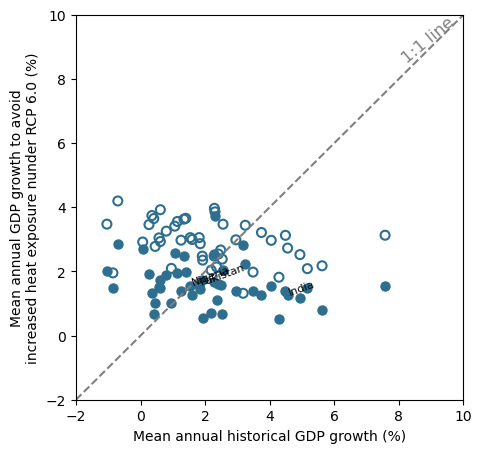

<Figure size 640x480 with 0 Axes>

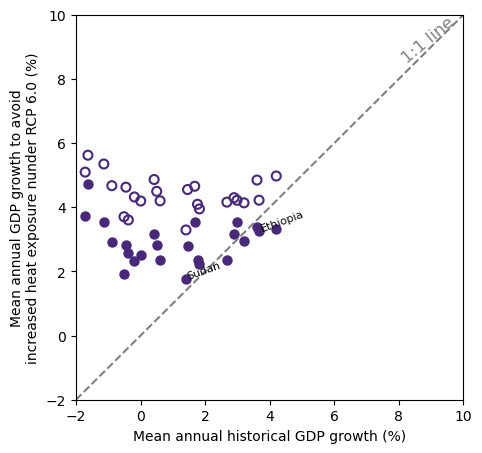

<Figure size 640x480 with 0 Axes>

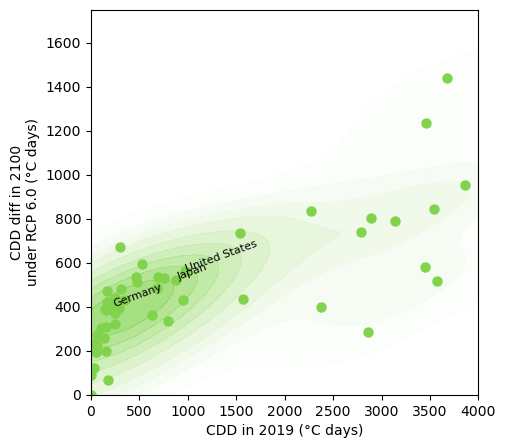

<Figure size 640x480 with 0 Axes>

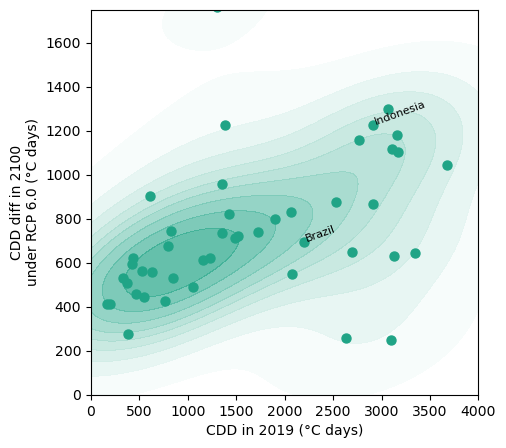

<Figure size 640x480 with 0 Axes>

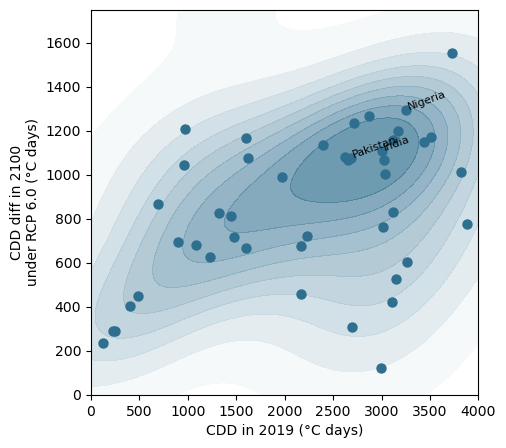

<Figure size 640x480 with 0 Axes>

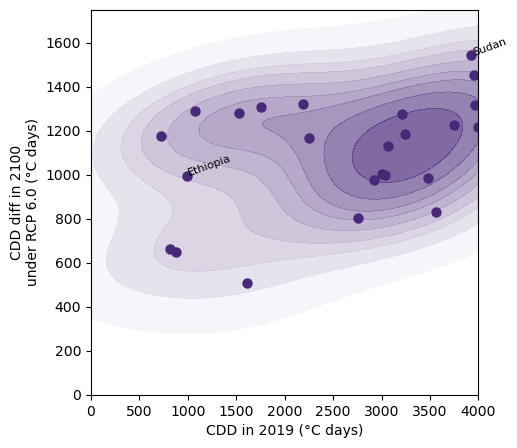

In [9]:
# Make all plots

for scenario in ['historical'] + config['future_scenarios']:

    if scenario == 'historical':
        vars = ['CDD', 'GDP']
    else:
        vars = ['CDD_{}_2100_diff'.format(scenario)]
    
    # Figure GDP and CDD maps (Fig.1)
    for var in vars:
        plot_variable_map(config, ac_data, var)
    
    if scenario == 'historical':
        # Plot maps highlighting income groups (Fig.2)
        plot_income_groups(config, ac_data)
        # Figure Contours (Fig.3)
        xrange = [config['plotting']['cdd_min'], config['plotting']['cooling_deficit_index_max'], 100]
        yrange = [config['plotting']['gdp_min'], config['plotting']['gdp_max'], 100]
        # AC adoption
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='AC_adoption_contour', multiply_cdd=False)
        # Cooling Deficit Index == Exposure times CDD
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='cooling_deficit_index_contour')        
        continue

    # Plot maps with GDP needed to keep exposure divided by historical GDP growth (Fig.4)
    ac_data['gdp_growth_parity_{}'.format(scenario)] = (ac_data['gdp_const_{}_custom_exp_cdd'.format(scenario)]) * 100
    plot_income_groups(config, ac_data, 'gdp_growth_parity_{}'.format(scenario))

    # Part of Figure GDP growth (Fig.4)
    plot_gdp_increase_scatter(config, ac_data, scenario)

    # Part of Figure CDD change (Fig.3)
    plot_cdd_scatter(config, ac_data, scenario)